This notebook shows how to use LLM-Geo, you can uncomment a study case (preferred Case 1 and Case 3) to get the spatial analysis results without any human intervention. 

Please check the [webpage of LLM-Geo](https://github.com/gladcolor/LLM-Geo) for more detail!


#  Install package

In [2]:
# ! pip install pyvis
# ! pip install networkx
# ! pip install openai

# Import package

In [1]:
import os
import requests
import networkx as nx
import pandas as pd
import geopandas as gpd
from pyvis.network import Network
from openai import OpenAI
from IPython.display import display, HTML, Code
from IPython.display import clear_output

# Define Solution class
Please run the following cell to define the functions

In [4]:
%load_ext autoreload
%autoreload 2

import LLM_Geo_Constants as constants
import helper

from LLM_Geo_kernel import Solution



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Demonstration Cases

## Input task and data desciption

In [13]:
isReview = True

In [5]:

# Case 1: population living near hazardous wastes

task_name ='Resident_at_risk_counting'
TASK = r"""1) Find out Census tracts that contain hazardous waste facilities, then comppute and print out the population living in those tracts. The study area is North Carolina (NC), US.
2) Generate a population choropleth map for all tract polygons in NC, rendering the color by tract population; and then highlight the borders of tracts that have hazardous waste facilities. Please draw all polygons, not only the highlighted ones. The map size is 15*10 inches.
"""

DATA_LOCATIONS = ["NC hazardous waste facility ESRI shape file: https://github.com/gladcolor/LLM-Geo/raw/master/overlay_analysis/HW_Sites_EPSG4326.zip.",
                  "NC tract boundary shapefile: https://github.com/gladcolor/LLM-Geo/raw/master/overlay_analysis/tract_37_EPSG4326.zip. The tract ID column is 'GEOID', data types is integer.",
                  "NC tract population CSV file: https://github.com/gladcolor/LLM-Geo/raw/master/overlay_analysis/NC_tract_population.csv. The population is stored in 'TotalPopulation' column. The tract ID column is 'GEOID', data types is integer."
                 ]
 


## Case 3: COVID-19 death rate in US
# task_name ='COVID_death_rate'
# TASK = r'''1) Draw a choropleth map to show the death rate (death/case) of COVID-19 among the countiguous US counties. Use the accumulated COVID-19 data of 2020.12.31 to compute the death rate. Use scheme ='quantiles' when plotting the map.  Set map projection to 'Conus Albers'. Set map size to 15*10 inches.  
# 2) Draw a scatter plot to show the correlation and trend line of the death rate with the senior resident rate, including the r-square and p-value. Set data point transparency to 50%, regression line as red. Set figure size to 15*10 inches.  
# '''


# DATA_LOCATIONS = [
#                   r"COVID-19 data case in 2020 (county-level): https://github.com/nytimes/covid-19-data/raw/master/us-counties-2020.csv. This data is for daily accumulated COVID cases and deaths for each county in the US. There are 5 columns: date (format: 2021-02-01), county, state, fips, cases, deaths. ",   
#                   r"Contiguous US county boundary (ESRI shapefile): https://github.com/gladcolor/spatial_data/raw/master/contiguous_counties.zip. The county FIPS column is 'GEOID'; map projection is EPSG:4269",
#                   r"Census data (ACS2020): https://raw.githubusercontent.com/gladcolor/spatial_data/master/Demography/ACS2020_5year_county.csv. THe needed columns are: 'FIPS', 'Total Population', 'Total Population: 65 to 74 Years', 'Total Population: 75 to 84 Years', 'Total Population: 85 Years and Over'. Drop rows with NaN cells after loading the used columns.",
#                  ]



# # Case 4: Hospital_accessibility
# task_name ='Hospital_accessibility'
# TASK = r'''
# For each zipcode area in South Carolina (SC), calculate the distance from the centroid of the zipcode area to its nearest hospital, and then create a choropleth distance map of zipcode area polygons (unit: km), also show the hospital.
# '''

# DATA_LOCATIONS = [
# r"SC zipcode boundary shapefile: https://github.com/GIBDUSC/test/raw/master/sc_zip_boundary.zip, the map projection is WGS1984.",
# r"SC hospitals:  https://github.com/gladcolor/spatial_data/raw/master/South_Carolina/SC_hospitals_with_emergency_room_cleaned.csv, location columns: longitude in 'POINT_X' column, latitude in 'POINT_Y' column.",          
# ]


## Case 5: Census API
# task_name ='Census_API'
# TASK = r''' Show the spatial distribution of the county level median income in the contigous US. Set figure size to (25,15)
# '''

# DATA_LOCATIONS = [
#       "You can use the Census API.",
# ]

# DATA_LOCATIONS = [
# '''Census API key: ae7be70727932dd6aed257692de3f344365d0678'''              
# ]


# # Case 2: France_mobility_changes_2020
# task_name ='France_mobility_changes_2020'
# TASK = r'''
# 1) Show the 2020 human mobility monthly change rates of each administrative regions in a France choropleth map. Each month is a sub-map in a map matrix，12 months in total. All monthly maps need to use the same colorbar range (color scheme: coolwarm). The base of the change rate is January 2020. 
# 2) Draw a line chart to show the monthly change rate trends of all administrative regeions. Each region is a line (the region name is the legend), the x-axis is 2020 months.
# '''

# DATA_LOCATIONS = ["ESRI shapefile for France administrative regions:" + \
#                   "https://github.com/gladcolor/LLM-Geo/raw/master/REST_API/France.zip. " + \
#                   "The 'GID_1' column is the administrative region code, 'NAME_1' column is the administrative region name.",
#                   "REST API url with parameters for daily human mobility data access:" + \
#                   "http://gis.cas.sc.edu/GeoAnalytics/REST?operation=get_daily_movement_for_all_places&source=twitter&scale=world_first_level_admin&begin=01/01/2020&end=12/31/2020." + \
#                   "The response is in CSV format. There are three columns in the response: " + \
#                   "place,date (format:2020-01-07), and intra_movement. 'place' column is the administractive region code of every country;" + \
#                   "codes for France administrative regions start with 'FRA'. Use the total intra_movement of the month as the montly mobility.",
#                  ]


save_dir = os.path.join(os.getcwd(), task_name)
os.makedirs(save_dir, exist_ok=True)

# create graph
# model=r"gpt-4"
model = r'gpt-4-turbo-preview'
solution = Solution(
                    task=TASK,
                    task_name=task_name,
                    save_dir=save_dir,
                    data_locations=DATA_LOCATIONS,
                    model=model,
                    )
print("Prompt to get solution graph:\n")
print(solution.graph_prompt)

Prompt to get solution graph:

Your role: A professional Geo-information scientist and programmer good at Python. You have worked on Geographic information science more than 20 years, and know every detail and pitfall when processing spatial data and coding. You know well how to set up workflows for spatial analysis tasks. You have significant experence on graph theory, application, and implementation. You are also experienced on generating map using Matplotlib and GeoPandas.
 

Your task: Generate a graph (data structure) only, whose nodes are (1) a series of consecutive steps and (2) data to solve this question:  
 1) Find out Census tracts that contain hazardous waste facilities, then comppute and print out the population living in those tracts. The study area is North Carolina (NC), US.
2) Generate a population choropleth map for all tract polygons in NC, rendering the color by tract population; and then highlight the borders of tracts that have hazardous waste facilities. Please d

## Get graph code from GPT API

In [9]:
response_for_graph = solution.get_LLM_response_for_graph() 
solution.graph_response = response_for_graph
solution.save_solution()

clear_output(wait=True)
display(Code(solution.code_for_graph, language='python'))

import networkx as nx

G = nx.DiGraph()

# Data nodes for input data paths
G.add_node("haz_waste_shp_url", node_type="data", data_path="https://github.com/gladcolor/LLM-Geo/raw/master/overlay_analysis/HW_Sites_EPSG4326.zip", description="URL for hazardous waste facility shapefile")
G.add_node("tract_shp_url", node_type="data", data_path="https://github.com/gladcolor/LLM-Geo/raw/master/overlay_analysis/tract_37_EPSG4326.zip", description="URL for NC tract boundary shapefile")
G.add_node("tract_pop_csv_url", node_type="data", data_path="https://github.com/gladcolor/LLM-Geo/raw/master/overlay_analysis/NC_tract_population.csv", description="URL for NC tract population CSV file")

# Operation nodes for loading the data
G.add_node("load_haz_waste_shp", node_type="operation", description="Load hazardous waste facility shapefile")
G.add_node("load_tract_shp", node_type="operation", description="Load NC tract boundary shapefile")
G.add_node("load_tract_pop_csv", node_type="operation", description="Load NC tract population CSV")

# Output data nodes from loading the data
G.add_node("haz_waste_gdf", node_type="data", description="Hazardous waste facility GeoDataFrame")
G.add_node("tract_gdf", node_type="data", description="NC tract boundary GeoDataFrame")
G.add_node("tract_pop_df", node_type="data", description="NC tract population DataFrame")

# Edges connecting data loading
G.add_edge("haz_waste_shp_url", "load_haz_waste_shp")
G.add_edge("tract_shp_url", "load_tract_shp")
G.add_edge("tract_pop_csv_url", "load_tract_pop_csv")
G.add_edge("load_haz_waste_shp", "haz_waste_gdf")
G.add_edge("load_tract_shp", "tract_gdf")
G.add_edge("load_tract_pop_csv", "tract_pop_df")

# Operation node for joining the population data to the tract boundaries
G.add_node("join_pop_to_tract", node_type="operation", description="Join population data to tract GeoDataFrame")
# Output data node from the join operation
G.add_node("tract_pop_gdf", node_type="data", description="GeoDataFrame of NC tracts with population data")

# Edges connecting the join operation
G.add_edge("tract_gdf", "join_pop_to_tract")
G.add_edge("tract_pop_df", "join_pop_to_tract")
G.add_edge("join_pop_to_tract", "tract_pop_gdf")

# Operation node for spatially joining hazardous waste sites to tracts
G.add_node("spatial_join_haz_to_tract", node_type="operation", description="Spatially join hazardous waste facilities to tracts")
# Output data node from spatial join
G.add_node("haz_tract_gdf", node_type="data", description="GeoDataFrame of tracts with hazardous waste facilities")

# Edges connecting the spatial join operation
G.add_edge("haz_waste_gdf", "spatial_join_haz_to_tract")
G.add_edge("tract_pop_gdf", "spatial_join_haz_to_tract")
G.add_edge("spatial_join_haz_to_tract", "haz_tract_gdf")

# Operation node for computing population in tracts with hazardous waste
G.add_node("compute_pop_in_haz_tract", node_type="operation", description="Compute and print population in tracts with hazardous waste facilities")
# Output data node from the computation
G.add_node("population_in_haz_tracts", node_type="data", description="Population in tracts with hazardous waste facilities")

# Edge for population computation
G.add_edge("haz_tract_gdf", "compute_pop_in_haz_tract")
G.add_edge("compute_pop_in_haz_tract", "population_in_haz_tracts")

# Operation node for generating the choropleth map
G.add_node("generate_choropleth_map", node_type="operation", description="Generate a population choropleth map with highlighted tracts containing hazardous waste facilities")
# Output data node from map generation
G.add_node("choropleth_map_path", node_type="data", data_path="F:\\Research\\LLM-Geo\\Resident_at_risk_counting\\population_choropleth_map.png", description="File path for the generated population choropleth map")

# Edges connecting map generation
G.add_edge("tract_pop_gdf", "generate_choropleth_map")
G.add_edge("haz_tract_gdf", "generate_choropleth_map")
G.add_edge("generate_choropleth_map", "choropleth_map_p

## Execute code to generate the solution graph

In [11]:
exec(solution.code_for_graph)
solution_graph = solution.load_graph_file()

# Show the graph
G = nx.read_graphml(solution.graph_file)  
nt = helper.show_graph(G)
html_name = os.path.join(os.getcwd(), solution.task_name + '.html')  
# HTML file should in the same directory. See:
# https://stackoverflow.com/questions/65564916/error-displaying-pyvis-html-inside-jupyter-lab-cell
nt.show(name=html_name)
# html_name

F:\Research\LLM-Geo\Resident_at_risk_counting.html


## Generate prompts and code for operations (functions)

In [26]:
operations = solution.get_LLM_responses_for_operations(review=isReview)
solution.save_solution()

all_operation_code_str = '\n'.join([operation['operation_code'] for operation in operations])

clear_output(wait=True)
display(Code(all_operation_code_str, language='python'))

import geopandas as gpd

def load_haz_waste_shp(haz_waste_shp_url='https://github.com/gladcolor/LLM-Geo/raw/master/overlay_analysis/HW_Sites_EPSG4326.zip'):
    # Description: Load hazardous waste facility shapefile from a given URL
    # haz_waste_shp_url: URL for the hazardous waste facility shapefile
    
    # Reading shapefile directly from the URL using GeoPandas
    haz_waste_gdf = gpd.read_file(haz_waste_shp_url)
    
    return haz_waste_gdf
import geopandas as gpd

def load_tract_shp(tract_shp_url='https://github.com/gladcolor/LLM-Geo/raw/master/overlay_analysis/tract_37_EPSG4326.zip'):
    """
    Load North Carolina tract boundary shapefile from a provided URL.
    The shapefile is loaded into a GeoDataFrame.
    
    Parameters:
    tract_shp_url (str): URL to the tract shapefile zip archive.
    
    Returns:
    GeoDataFrame: GeoDataFrame containing the tract boundaries.
    """
    # Load the shapefile directly from the URL using GeoPandas
    tract_gdf = gpd.read_file(tract_shp_url)
    
    # Return the loaded GeoDataFrame
    return tract_gdf
import pandas as pd

def load_tract_pop_csv(tract_pop_csv_url='https://github.com/gladcolor/LLM-Geo/raw/master/overlay_analysis/NC_tract_population.csv'):
    # Description: Load NC tract population CSV
    # tract_pop_csv_url: URL for NC tract population CSV file
    tract_pop_df = pd.read_csv(tract_pop_csv_url, dtype={'GEOID': str})
    tract_pop_df.dropna(subset=['TotalPopulation'], inplace=True)
    return tract_pop_df
def join_pop_to_tract(tract_gdf, tract_pop_df):
    """
    Join population data to tract GeoDataFrame based on the GEOID.
    
    Parameters:
    tract_gdf (GeoDataFrame): GeoDataFrame containing the tract boundaries.
    tract_pop_df (DataFrame): DataFrame containing the population data for each tract.
    
    Returns:
    GeoDataFrame: GeoDataFrame of NC tracts with population data added.
    """
    # Ensure GEOID column in tract_pop_df is a string to match types
    tract_pop_df['GEOID'] = tract_pop_df['GEOID'].astype(str)

    # Merge the population data into the tract GeoDataFrame on GEOID
    tract_pop_gdf = tract_gdf.merge(tract_pop_df, on='GEOID', how='left')

    # Dropping rows where population data might be missing
    tract_pop_gdf.dropna(subset=['TotalPopulation'], inplace=True)

    return tract_pop_gdf
import geopandas as gpd

def spatial_join_haz_to_tract(haz_waste_gdf, tract_pop_gdf):
    """
    Spatially join hazardous waste facilities to tracts.
    
    Parameters:
    haz_waste_gdf (GeoDataFrame): GeoDataFrame containing hazardous waste facilities.
    tract_pop_gdf (GeoDataFrame): GeoDataFrame containing tract boundaries with population data.
    
    Returns:
    GeoDataFrame: GeoDataFrame of tracts with hazardous waste facilities, including tract population.
    """
    # Performing spatial join of hazardous waste facilities to tracts
    haz_tract_gdf = gpd.sjoin(tract_pop_gdf, haz_waste_gdf, how='inner', predicate='intersects')
    
    # Removing duplicate entries to ensure each tract is represented once
    haz_tract_gdf = haz_tract_gdf.drop_duplicates(subset='GEOID')

    return haz_tract_gdf
def compute_pop_in_haz_tract(haz_tract_gdf):
    """
    Compute and print the population in tracts with hazardous waste facilities.
    
    Parameters:
    haz_tract_gdf (GeoDataFrame): GeoDataFrame of tracts with hazardous waste facilities, including population data.
    
    Returns:
    int: Total population in tracts with hazardous waste facilities.
    """
    # Summing up the population of the tracts that contain hazardous waste facilities
    population_in_haz_tracts = haz_tract_gdf['TotalPopulation'].sum()

    # Print out the total population in tracts with hazardous waste facilities
    print(f"Total population in tracts with hazardous waste facilities: {population_in_haz_tracts}")
    
    return population_in_haz_tracts
import matplotlib.pyplot as plt

def generate_choropleth_map(tract_pop_gdf, haz_tract_gdf):
    "

## Generate prompts and code for assembly program

In [28]:
assembly_LLM_response = solution.get_LLM_assembly_response(review=isReview)
solution.assembly_LLM_response = assembly_LLM_response
solution.save_solution()

clear_output(wait=True)
display(Code(solution.code_for_assembly, language='python'))

import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

def load_haz_waste_shp(haz_waste_shp_url='https://github.com/gladcolor/LLM-Geo/raw/master/overlay_analysis/HW_Sites_EPSG4326.zip'):
    haz_waste_gdf = gpd.read_file(haz_waste_shp_url)
    return haz_waste_gdf

def load_tract_shp(tract_shp_url='https://github.com/gladcolor/LLM-Geo/raw/master/overlay_analysis/tract_37_EPSG4326.zip'):
    tract_gdf = gpd.read_file(tract_shp_url)
    tract_gdf['GEOID'] = tract_gdf['GEOID'].astype(str)  # Ensure GEOID is string for successful merge
    return tract_gdf

def load_tract_pop_csv(tract_pop_csv_url='https://github.com/gladcolor/LLM-Geo/raw/master/overlay_analysis/NC_tract_population.csv'):
    tract_pop_df = pd.read_csv(tract_pop_csv_url, dtype={'GEOID': 'str'})
    tract_pop_df.dropna(subset=['TotalPopulation'], inplace=True)
    return tract_pop_df

def join_pop_to_tract(tract_gdf, tract_pop_df):
    tract_pop_gdf = tract_gdf.merge(tract_pop_df, on='GEOID', how='left')
    tract_pop_gdf.dropna(subset=['TotalPopulation'], inplace=True)  # Removing tracts without population data ensures accurate analysis
    return tract_pop_gdf

def spatial_join_haz_to_tract(haz_waste_gdf, tract_pop_gdf):
    haz_tract_gdf = gpd.sjoin(tract_pop_gdf, haz_waste_gdf, how='inner', predicate='intersects')
    haz_tract_gdf.drop_duplicates(subset='GEOID', inplace=True)  # Correcting for any duplication arising from sjoin operation
    return haz_tract_gdf

def compute_pop_in_haz_tract(haz_tract_gdf):
    population_in_haz_tracts = haz_tract_gdf['TotalPopulation'].sum()
    print(f"Total population in tracts with hazardous waste facilities: {population_in_haz_tracts}")
    return population_in_haz_tracts

def generate_choropleth_map(tract_pop_gdf, haz_tract_gdf):
    fig, ax = plt.subplots(figsize=(15, 10))
    tract_pop_gdf.plot(column='TotalPopulation', ax=ax, legend=True,
                       legend_kwds={'label': "Population by Tract", 'orientation': "horizontal"},
                       cmap='YlGn', scheme='quantiles')
    if not haz_tract_gdf.empty:
        haz_tract_gdf.plot(ax=ax, edgecolor='red', linewidth=2, facecolor="none")
    ax.set_title("North Carolina Census Tracts - Population Choropleth Map with Hazardous Waste Tracts Highlighted")
    ax.set_axis_off()
    
    plt.savefig("population_choropleth_map.png")
    return "population_choropleth_map.png"

def assemble_solution():
    haz_waste_gdf = load_haz_waste_shp()
    tract_gdf = load_tract_shp()
    tract_pop_df = load_tract_pop_csv()
    tract_pop_gdf = join_pop_to_tract(tract_gdf, tract_pop_df)
    haz_tract_gdf = spatial_join_haz_to_tract(haz_waste_gdf, tract_pop_gdf)
    compute_pop_in_haz_tract(haz_tract_gdf)
    return generate_choropleth_map(tract_pop_gdf, haz_tract_gdf)

assemble_solution()

## Execute assembly code



-------------- Running code (trial # 1/10) --------------


Total population in tracts with hazardous waste facilities: 5683893
Error_info_str: 
Traceback (most recent call last):
  File "Complete program", line 184, in <module>
    assemble_solution()
  File "Complete program", line 182, in assemble_solution
    return generate_choropleth_map(tract_pop_gdf, haz_tract_gdf)
  File "Complete program", line 164, in generate_choropleth_map
    tract_pop_gdf.plot(column='TotalPopulation', ax=ax, legend=True,
  File "d:\ProgramData\anaconda3\envs\llm_geo\Lib\site-packages\geopandas\plotting.py", line 979, in __call__
    return plot_dataframe(data, *args, **kwargs)
  File "d:\ProgramData\anaconda3\envs\llm_geo\Lib\site-packages\geopandas\plotting.py", line 957, in plot_dataframe
    ax.legend(**legend_kwds)
  File "d:\ProgramData\anaconda3\envs\llm_geo\Lib\site-packages\matplotlib\axes\_axes.py", line 323, in legend
    self.legend_ = mlegend.Legend(self, handles, labels, **kwargs)
TypeErr

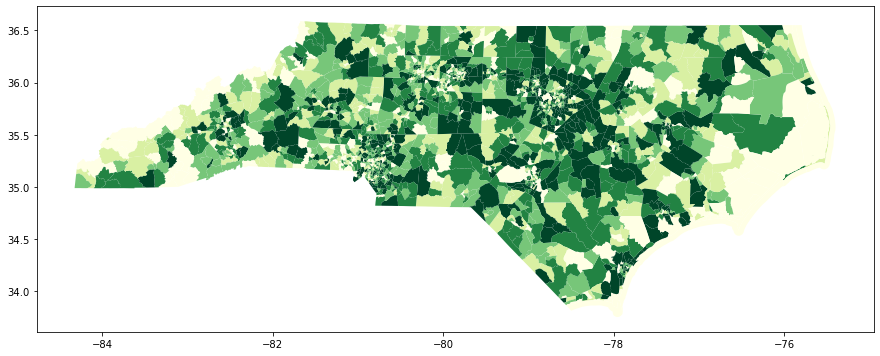

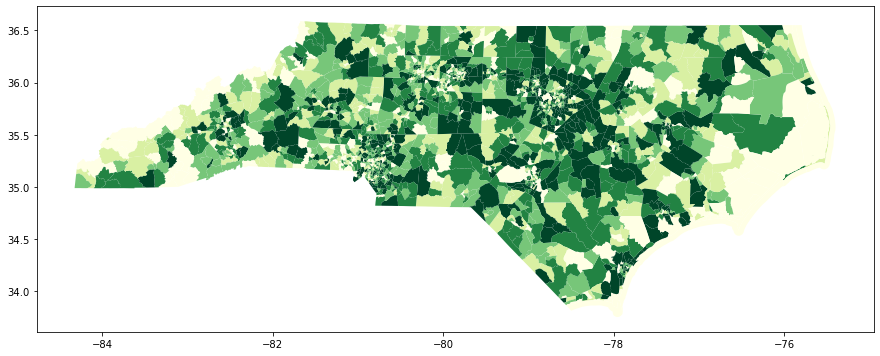

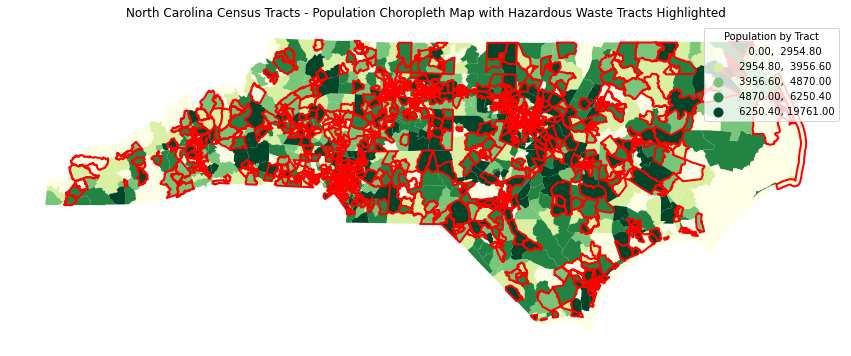

In [29]:
all_code = all_operation_code_str + '\n' + solution.code_for_assembly

# display(Code(all_code, language='python'))

all_code = solution.execute_complete_program(code=all_code, try_cnt=10)